## LDA
Линейный дискриминантный анализ (linear discriminant analysis, LDA), он же канонический, может использоваться в качестве методов для выделения признаков в целях увеличения вычислительной эффективности и уменьшения степени переобучения из-за проблемы проклятия размерности в нерегуляризованных моделях.

Ключевые шаги алгоритма:
1. стандартизировать $d$-менрный набор данных;
2. для каждого класса вычислить $d$-мерный вектор средних;
3. создать матрицу разброса между классами $S_B$ и матрицу разбросов внутри класса $S_W$;
4. вычислить собственные векторы и собственные значения $S_W^{-1}S_B$;
5. выбрать $k$ собственных векторов, которые соответствуют $k$ самым большим собственным значениям для построения $d \times k$-матрицы преобразования $W$; собственные векторы являются столбцами этой матрицы;
6. спроецировать образцы на новое подпространство признаков при помощи матрицы преобразования $W$.

При использовании LDA мы делаем допущение, что признаки нормально распределены и независиы друг от друга.

Для построения матриц разброса вычислим вектора средних значений признаков
$$ m_i = \frac{1}{n_i}\sum_{x \in D_i}^c x_m $$
где каждый вектор $m_i$ хранит среднее значение $\mu_m$ отностильено образцов класса $i$.

In [32]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [33]:
df = pd.read_csv('../data/wine/wine.data', header=None)

X, y = df.iloc[:, 1:].values, df.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=0)
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [34]:
np.set_printoptions(precision=4)
mean_vecs = []
for label in range(1, 4):
    mean_vecs.append(np.mean(X_train_std[y_train==label], axis=0))
    print('Bектор средних класса {0}:\n {1}\n'.format(label, mean_vecs[label - 1]))

Bектор средних класса 1:
 [ 0.9259 -0.3091  0.2592 -0.7989  0.3039  0.9608  1.0515 -0.6306  0.5354
  0.2209  0.4855  0.798   1.2017]

Bектор средних класса 2:
 [-0.8727 -0.3854 -0.4437  0.2481 -0.2409 -0.1059  0.0187 -0.0164  0.1095
 -0.8796  0.4392  0.2776 -0.7016]

Bектор средних класса 3:
 [ 0.1637  0.8929  0.3249  0.5658 -0.01   -0.9499 -1.228   0.7436 -0.7652
  0.979  -1.1698 -1.3007 -0.3912]



Теперь, используя вектора средних, можно вычислить матрицу разброса точек внутри класса $S_W$
$$ S_W =  \sum_{i=1}^c S_i $$
Она вычисляется путем суммирования индивидуальных матриц разброса $S_i$, каждого индивидуального класса $i$
$$ S_i = \sum_{x \in D_i} (x - m_i) (x - m_i)^T $$

In [35]:
d = 13 # feature count
S_W = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.zeros((d, d))
    for row in X_train_std[y_train==label]:
        row, mv = row.reshape(d, 1), mv.reshape(d, 1)
        class_scatter += (row - mv).dot((row - mv).T)
    S_W += class_scatter
print('Внутриклассовая матрица разброса: {0}x{1}'.format(S_W.shape[0], S_W.shape[1]))

Внутриклассовая матрица разброса: 13x13


Во время вычисления матрицы разброса, мы допускаем что метки классов в тренировочном наборе распределены равномерно, но это не так. 

In [36]:
print('Распределение меток классов: {}'.format(np.bincount(y_train)[1:]))

Распределение меток классов: [40 49 35]


Можно заметить, что вычисление матрицы расброса фактически не отличается от вычисления ковариационной матрицы. Ковариационная матрица - нормализованная версия матрицы разброса.
$$ \Sigma_i = \frac{1}{N_i}S_W = \frac{1}{N_i}\sum_{x \in D_i}^c (x - m_i) (x - m_i)^T $$

In [37]:
d = 13 # feature count
S_W = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.cov(X_train_std[y_train==label].T)
    S_W += class_scatter
print('Маштабированная внутриклассовая матрица разброса: {0}x{1}'.format(S_W.shape[0], S_W.shape[1]))

Маштабированная внутриклассовая матрица разброса: 13x13


Следующий шаг вычисление матрица разброса между классами
$$ S_B = \sum_{i=1}^c N_i (m_i - m) (m_i - m)^T$$
здесь $m$ - общее среднее, вклчающее в себя образцы из всех классов

In [38]:
mean_overall = np.mean(X_train_std, axis=0)
d = 13
S_B = np.zeros((d, d))
for i, mean_vec in enumerate(mean_vecs):
    n = X_train[y_train == i + 1, :].shape[0]
    mean_vec = mean_vec.reshape(d, 1)
    mean_overall = mean_overall.reshape(d, 1)
    S_B += n * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)


In [47]:
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))
eigen_pars = [(np.abs(eigen_vals[i]), eigen_vecs[:, i])
              for i in range(len(eigen_vals))]
eigen_pars = sorted(eigen_pars, 
                    key=lambda x: x[0], reverse=True)
print('Собственные векторы')
for eigen_val in eigen_pars:
    print(eigen_val[0])

Собственные векторы
452.72158124497423
156.43636121952332
7.213714786941234e-14
3.301126601072513e-14
2.842170943040401e-14
2.0789123661254802e-14
2.0789123661254802e-14
1.9157857744914097e-14
1.485235281436693e-14
1.485235281436693e-14
1.2649474133422451e-14
3.820024625504893e-15
1.4889922632549732e-15


В LDA число линейных компонентов не превышает $c - 1$, где $c$ число меток классов. 

/Users/tbb/Virtualenvs/venv/lib/python3.6/site-packages/matplotlib/transforms.py:827: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.array(args, dtype=float).reshape(2, 2)
/Users/tbb/Virtualenvs/venv/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


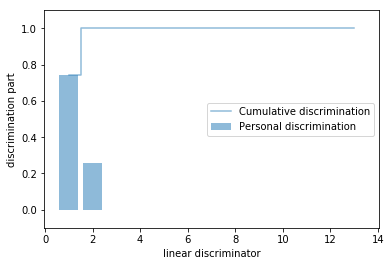

In [48]:
total = sum(eigen_vals)
discr = [(i / total) for i in sorted(eigen_vals.real, reverse=True)]
cum_discr = np.cumsum(discr)
plt.bar(range(1, 14), discr, alpha=.5, align='center',
        label='Personal discrimination')
plt.step(range(1, 14), cum_discr, alpha=.5, where='mid',
        label='Cumulative discrimination')
plt.ylabel('discrimination part')
plt.xlabel('linear discriminator')
plt.ylim([-0.1, 1.1])
plt.legend(loc='best')
plt.show()

Выделим первые для столбца для создания матрицы преобразования

In [50]:
w = np.hstack((eigen_pars[0][1][:, np.newaxis].real,
               eigen_pars[1][1][:, np.newaxis].real))
print('Матрица W:\n', w)

Матрица W:
 [[-0.0662 -0.3797]
 [ 0.0386 -0.2206]
 [-0.0217 -0.3816]
 [ 0.184   0.3018]
 [-0.0034  0.0141]
 [ 0.2326  0.0234]
 [-0.7747  0.1869]
 [-0.0811  0.0696]
 [ 0.0875  0.1796]
 [ 0.185  -0.284 ]
 [-0.066   0.2349]
 [-0.3805  0.073 ]
 [-0.3285 -0.5971]]


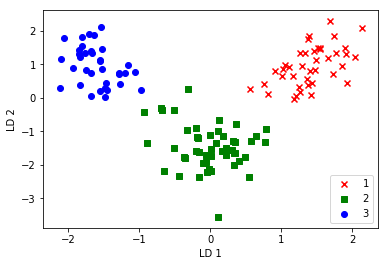

In [51]:
X_train_lda = X_train_std.dot(w)
colors = ['r', 'g', 'b']
markers = ['x', 's', 'o']
for label, color, marker in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_lda[y_train==label, 0] * (-1),
                X_train_lda[y_train==label, 1] * (-1),
                c=color, label=label, marker=marker)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower right')
plt.show()

### Рассмотрим реализацю в sklearn

In [59]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from mutils import *

In [61]:
lda = LinearDiscriminantAnalysis(n_components=2)
X_train_lda = lda.fit_transform(X_train_std, y_train)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


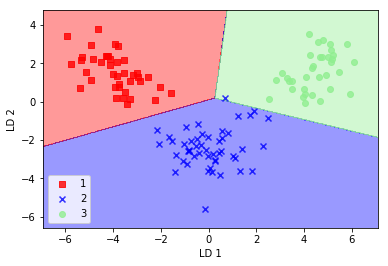

In [64]:
lr = LogisticRegression(solver='liblinear',
                        multi_class='ovr')
lr.fit(X_train_lda, y_train)
plot_decision_regions(X_train_lda, y_train, clf=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='best')
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


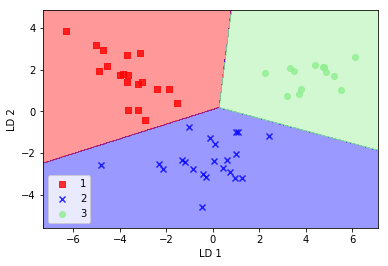

In [65]:
X_test_lda = lda.transform(X_test_std)
plot_decision_regions(X_test_lda, y_test, clf=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='best')
plt.show()